# Preprocessing Pipeline

This notebook prepared medical data for machine learning tasks focused on predicting cancer severity scores.

The following preprocessing steps were applied:

- **Missing value handling** and data cleaning  
- **Encoding** of categorical variables  
- **Correlation analysis** to identify influential features  
- **Feature scaling** to normalize numerical inputs  
- **Pipeline construction** for streamlined and reproducible model training


# 1. Dataset Setup

In [1]:
import pandas as pd
import numpy as np
import joblib

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("data/global_cancer_patients_2015_2024.csv")
df.drop(columns=["Patient_ID"], inplace=True)
df.head()

,Age,Gender,Country_Region,Year,Genetic_Risk,Air_Pollution,Alcohol_Use,Smoking,Obesity_Level,Cancer_Type,Cancer_Stage,Treatment_Cost_USD,Survival_Years,Target_Severity_Score
0,71,Male,UK,2021,6.4,2.8,9.5,0.9,8.7,Lung,Stage III,62913.44,5.9,4.92
1,34,Male,China,2021,1.3,4.5,3.7,3.9,6.3,Leukemia,Stage 0,12573.41,4.7,4.65
2,80,Male,Pakistan,2023,7.4,7.9,2.4,4.7,0.1,Breast,Stage II,6984.33,7.1,5.84
3,40,Male,UK,2015,1.7,2.9,4.8,3.5,2.7,Colon,Stage I,67446.25,1.6,3.12
4,43,Female,Brazil,2017,5.1,2.8,2.3,6.7,0.5,Skin,Stage III,77977.12,2.9,3.62


# 2. Feature Preparation

## 2.1 Drop Leakage Columns

To prevent data leakage and maintain a general-purpose preprocessing pipeline, the following columns were removed:

- **`Treatment_Cost_USD`** – Not available at inference time; determined after diagnosis and treatment.
- **`Survival_Years`** – Represents future outcomes and should not be used during training.
- **`cancer_stage`** – A post-diagnosis label that may be derived from or highly correlated with severity.

Removing these columns ensures that the model only learns from information available prior to or at the time of diagnosis.


In [3]:
df.drop(columns=["Treatment_Cost_USD", "Survival_Years", "Cancer_Stage"], inplace=True)
df.head()

,Age,Gender,Country_Region,Year,Genetic_Risk,Air_Pollution,Alcohol_Use,Smoking,Obesity_Level,Cancer_Type,Target_Severity_Score
0,71,Male,UK,2021,6.4,2.8,9.5,0.9,8.7,Lung,4.92
1,34,Male,China,2021,1.3,4.5,3.7,3.9,6.3,Leukemia,4.65
2,80,Male,Pakistan,2023,7.4,7.9,2.4,4.7,0.1,Breast,5.84
3,40,Male,UK,2015,1.7,2.9,4.8,3.5,2.7,Colon,3.12
4,43,Female,Brazil,2017,5.1,2.8,2.3,6.7,0.5,Skin,3.62


## 2.2 Identify Numeric & Categorical Columns

Features were classified into **numerical** and **categorical** types to ensure appropriate preprocessing:

- **Numerical features** will be scaled for consistency.
- **Categorical features** will be one-hot encoded to convert them into machine-readable format.


In [4]:
numeric_cols = ["Age", "Year", "Genetic_Risk", "Air_Pollution", 
                "Alcohol_Use", "Smoking", "Obesity_Level"]

categorical_cols = ["Gender", "Country_Region", "Cancer_Type"]

## 2.3 Separate Features & Target

In [5]:
X = df.drop(columns=["Target_Severity_Score"])
y = df["Target_Severity_Score"]

# 3. Data Splitting

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# 4. Preprocessing Pipeline

Modular preprocessing pipelines were constructed using `sklearn.pipeline.Pipeline` and `ColumnTransformer`.

This design ensured that preprocessing is:

- **Scalable** across different models and datasets  
- **Reusable** for both training and inference  
- **Consistent**, minimizing data leakage and preprocessing discrepancies


## 4.1 Build Numerical Transformers

Numerical features were standardized using `StandardScaler` to normalize feature distributions.

In [7]:
# Pipelines
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
# Scales data to have mean 0 and std 1

## 4.2 Build Categorical Transformers

Categorical features were transformed using **one-hot encoding** to convert each category into a binary numerical format.  


In [8]:
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

## 4.3 Combine Transformers

The numeric and categorical preprocessing pipelines were combined using a `ColumnTransformer`.  

In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

## 4.4 Apply Preprocessor

The combined preprocessing pipeline was applied to the feature set to produce the final transformed dataset.  

This included fitting the pipeline and transforming the input features, ensuring that all numeric and categorical columns were processed consistently and reproducibly.


In [10]:
# Fit on training data only
X_train_transformed = preprocessor.fit_transform(X_train)

# Transform test data
X_test_transformed = preprocessor.transform(X_test)

## 4.5 Save Transformed Data and Pipeline

In [11]:
# Save preprocessed feature matrices
joblib.dump(X_train_transformed, "data/X_train_transformed.pkl")
joblib.dump(X_test_transformed, "data/X_test_transformed.pkl")
joblib.dump(y_train, "data/y_train.pkl")
joblib.dump(y_test, "data/y_test.pkl")

['data/y_test.pkl']

In [12]:
joblib.dump(preprocessor, "models/preprocessor.pkl")

['models/preprocessor.pkl']

In [13]:
# Access OneHotEncoder inside the "cat" pipeline
encoder = preprocessor.named_transformers_["cat"].named_steps["onehot"]

# Now get categories
category_lists = encoder.categories_

# Unpack them
gender_categories, country_categories, cancer_categories = category_lists

print("Gender:", gender_categories)
print("Country:", country_categories)
print("Cancer Type:", cancer_categories)

Gender: ['Female' 'Male' 'Other']
Country: ['Australia' 'Brazil' 'Canada' 'China' 'Germany' 'India' 'Pakistan'
 'Russia' 'UK' 'USA']
Cancer Type: ['Breast' 'Cervical' 'Colon' 'Leukemia' 'Liver' 'Lung' 'Prostate' 'Skin']


# 5. PCA and Dimensionality Analysis

Principal Component Analysis (PCA) was applied to better understand the structure of the feature space after preprocessing.

This section covered:

- **Unsupervised dimensionality reduction**
- **Visualization of PCA projections**
- **Insights into component importance** and alignment with the target variable


In [14]:
df_x = joblib.load("data/x_train_transformed.pkl")
df_y = joblib.load("data/y_train.pkl")

In [15]:
df_x = pd.DataFrame(df_x)
df_x.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,-0.316156,-0.517507,-1.524973,-1.458101,-1.560692,-1.212144,0.176681,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.067039,1.221397,-0.069285,1.105793,1.101969,-0.448683,-0.099713,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.215239,-1.560850,1.074469,-1.527396,0.825329,0.627103,0.487623,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.363438,0.873616,1.282425,1.105793,0.202889,-0.309872,0.729468,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-1.155954,1.569178,-1.282358,-0.695862,1.482349,-1.455063,-0.894344,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## 5.1 Visualize Feature Space

The first two principal components were used to project the high-dimensional feature space into a 2D plane for visualization.

This unsupervised transformation helped reveal latent structure, spread, and clustering patterns within the dataset.


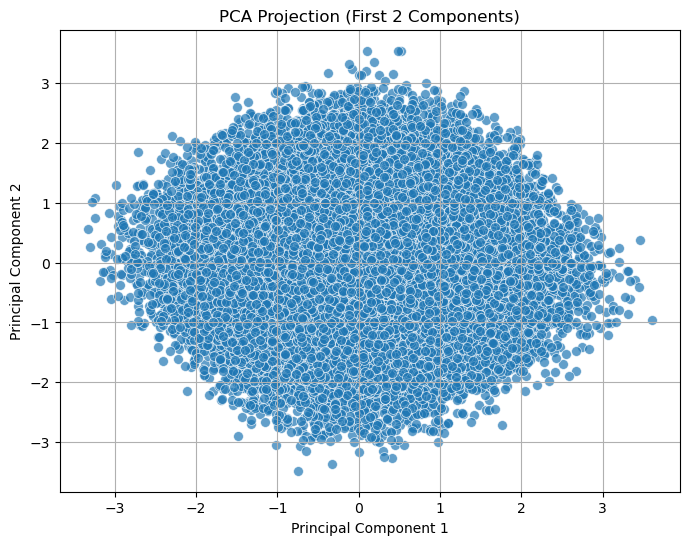

Explained Variance (PC1): 10.81%, (PC2): 10.72%


In [16]:
# Apply PCA after preprocessing
X_processed = df_x
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_processed)

# Plot PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], s=50, alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection (First 2 Components)')
plt.grid(True)
plt.show()

# Variance Explained
explained = pca.explained_variance_ratio_
print(f"Explained Variance (PC1): {explained[0]:.2%}, (PC2): {explained[1]:.2%}")

- The variance was fairly **evenly spread** among features, indicating that no single principal component dominated the dataset.

- The 2D projection shows a **dense, elliptical cloud** without visible clusters, suggesting that the data is well-centered and properly scaled.

- PCA captures meaningful but diffuse structure. It is a safe transformation — informative, but not transformative.


## 5.2 Color PCA Scatter Plot by Target

The 2D PCA projection was visualized with points colored by `Target_Severity_Score` to examine whether low-dimensional structure aligned with severity progression.

This helped reveal whether the target variable followed any **smooth gradient** or **clustered pattern** in principal component space.


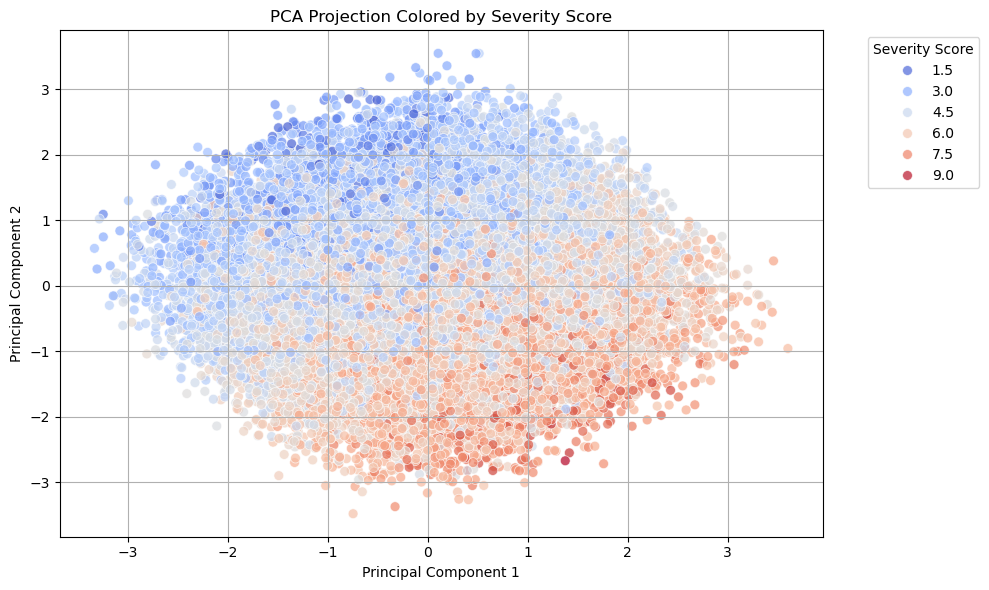

In [17]:
target = df_y

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=pca_result[:, 0],
    y=pca_result[:, 1],
    hue=target,
    palette="coolwarm",
    s=50,
    alpha=0.7
)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection Colored by Severity Score")
plt.legend(title="Severity Score", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

- The PCA projection colored by `Target_Severity_Score` showed a **smooth gradient**, with severity increasing from top-left to bottom-right.

- However, there was significant overlap between samples, indicating that the gradient was not sharply defined.

- PCA captured some **target-relevant variance**. While it did not reveal strong feature-target alignment, it proved useful for **mild dimensionality compression** without performance loss.


## 5.3 Scree Plot (Explained Variance)

A scree plot of cumulative explained variance was used to analyze how many principal components were needed to retain a high percentage of the dataset’s variance (e.g., 90%).

This helped guide dimensionality reduction decisions in later modeling steps.


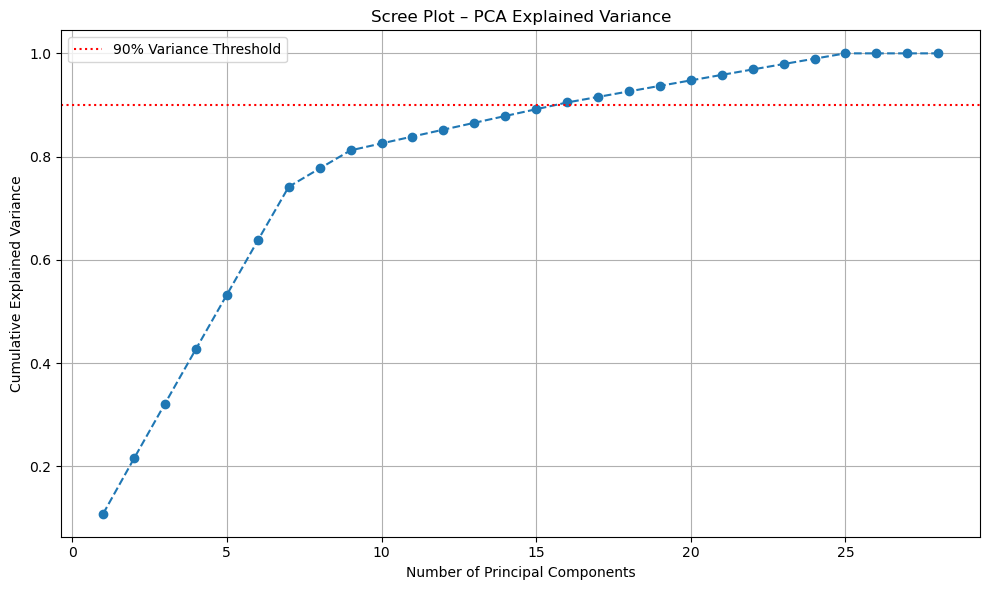

In [18]:
# Fit PCA on all components
pca_full = PCA().fit(X_processed)

# Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(pca_full.explained_variance_ratio_) + 1),
    np.cumsum(pca_full.explained_variance_ratio_),
    marker='o', linestyle='--'
)
plt.axhline(y=0.90, color='r', linestyle=':', label='90% Variance Threshold')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Scree Plot – PCA Explained Variance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- The **first 8 components** explained approximately **80%** of the total variance.

- Around **15 components** were required to reach **90% cumulative explained variance**.

- These results indicated that the dataset had **moderate intrinsic dimensionality** — making dimensionality reduction feasible, but requiring a reasonable number of components to preserve information.


## 5.4 Summary

- PCA confirmed that the data was **well-preprocessed** and **balanced**.

- While **2D PCA** was not sufficient for full class separability, it revealed meaningful structure aligned with **severity progression**.

- Based on the scree plot, using the **top 10–15 components** offered a reasonable trade-off between **dimensionality reduction** and **information retention**.

- PCA can be applied as an **optional enhancement** to reduce redundancy and simplify the feature space, though it is **not expected to significantly boost accuracy** on its own.
